# GAT-based Community Detection and Recommendation System

## 1. Environment Setup
Install required dependencies

In [1]:
# Install required dependencies
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
!pip install datasets transformers scikit-learn networkx python-louvain tqdm seaborn matplotlib pillow pandas numpy requests faiss-cpu

Looking in indexes: https://download.pytorch.org/whl/cu128
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 609.6/609.6 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 138.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 726.9/726.9 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

## 2. Import Necessary Libraries

In [22]:
import os
import json
import time
import requests
from concurrent.futures import ThreadPoolExecutor
from collections import defaultdict
import re
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, transforms

from transformers import BertTokenizer, BertModel
from datasets import Dataset
import networkx as nx
from community import community_louvain
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import faiss

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

# Clear GPU cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Using device: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3. Data Loading and Preprocessing
Implement efficient data loading and preprocessing

Loading JSON data: 0it [00:00, ?it/s]

Processing entries:   0%|          | 0/1487747 [00:00<?, ?it/s]


Dataset Statistics:
Total samples: 670,352
Unique users: 360,740
Unique businesses: 56,669

Rating Distribution:


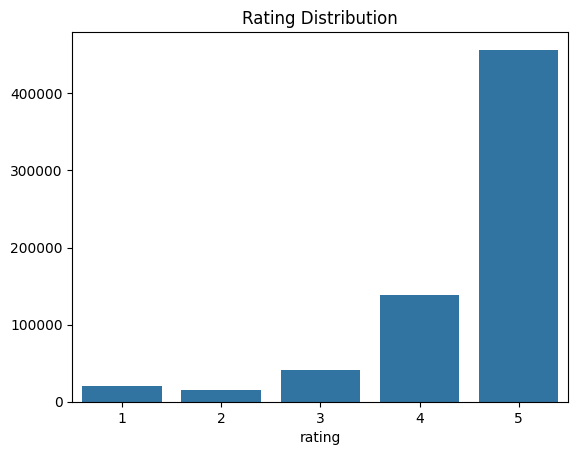

In [3]:
class DataPreprocessor:
    """Data preprocessing class"""

    def __init__(self, json_path: str, sample_frac: float = 0.2):
        self.json_path = json_path
        self.sample_frac = sample_frac

    def load_data(self) -> Dataset:
        """Load and preprocess data"""
        try:
            with open(self.json_path) as f:
                data = [json.loads(line) for line in tqdm(f, desc="Loading JSON data")]

            # Extract required fields
            rows = [{
                'business_id': entry['business_id'],
                'user_id': entry['user_id'],
                'rating': entry['rating'],
                'review_text': entry.get('review_text', ''),
                'pic_url': pic['url'][0]
            } for entry in tqdm(data, desc="Processing entries")
              for pic in entry.get('pics', [])]

            df = pd.DataFrame(rows)
            if self.sample_frac < 1.0:
                df = df.sample(frac=self.sample_frac, random_state=SEED)
                df = df.reset_index(drop=True)

            self._print_statistics(df)
            return Dataset.from_pandas(df)

        except Exception as e:
            print(f"Error loading data: {str(e)}")
            raise

    def _print_statistics(self, df: pd.DataFrame) -> None:
        """Print dataset statistics"""
        print("\nDataset Statistics:")
        print(f"Total samples: {len(df):,}")
        print(f"Unique users: {df['user_id'].nunique():,}")
        print(f"Unique businesses: {df['business_id'].nunique():,}")
        print("\nRating Distribution:")
        rating_dist = df['rating'].value_counts().sort_index()
        sns.barplot(x=rating_dist.index, y=rating_dist.values)
        plt.title("Rating Distribution")
        plt.show()

# Load data
preprocessor = DataPreprocessor('/content/drive/MyDrive/CMPE256-Team_Project/dataset/image_review_all.json')
dataset = preprocessor.load_data()

## 4. Image Download and Processing

In [4]:
class ImageDownloader:
    """Image download manager"""

    def __init__(self, save_dir: str, max_workers: int = 20, max_retries: int = 3):
        self.save_dir = save_dir
        self.max_workers = max_workers
        self.max_retries = max_retries
        os.makedirs(save_dir, exist_ok=True)

    def download_images(self, urls: List[str]) -> Tuple[int, int]:
        """Batch download images"""
        success_count = 0
        fail_count = 0

        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            futures = []
            for idx, url in enumerate(urls):
                save_path = os.path.join(self.save_dir, f"{idx}.jpg")
                if not os.path.exists(save_path):
                    futures.append(executor.submit(self._download_single, url, save_path))

            for f in tqdm(futures, desc="Downloading images"):
                if f.result():
                    success_count += 1
                else:
                    fail_count += 1

        return success_count, fail_count

    def _download_single(self, url: str, save_path: str) -> bool:
        """Download single image"""
        for attempt in range(self.max_retries):
            try:
                response = requests.get(url, timeout=5)
                response.raise_for_status()
                with open(save_path, 'wb') as f:
                    f.write(response.content)
                return True
            except Exception as e:
                if attempt == self.max_retries - 1:
                    print(f"Download failed {url}: {str(e)}")
                time.sleep(1)
        return False

# Download images
image_dir = '/content/drive/MyDrive/CMPE256-Team_Project/full_dataset_images'
if not os.path.exists(image_dir):
    downloader = ImageDownloader(image_dir)
    success, fail = downloader.download_images(dataset.to_pandas()['pic_url'].tolist())
    print(f"\nDownload Statistics:\nSuccess: {success}\nFail: {fail}\nTotal: {success + fail}")

## 5. Community Detection

Building graph...


Building graph:   0%|          | 0/360740 [00:00<?, ?it/s]

Detecting communities...

Detected 393 communities
Average community size: 1644.7
Maximum community size: 143606
Minimum community size: 2


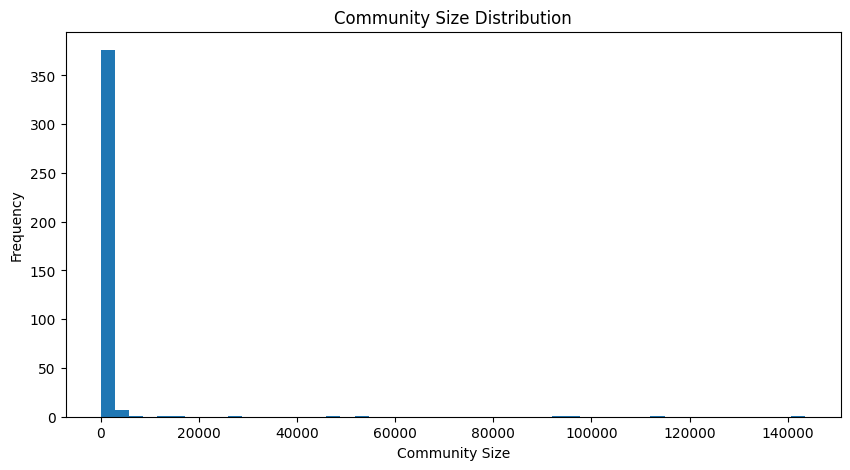

In [5]:
class CommunityDetector:
    """Community detector"""

    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.graph = nx.Graph()
        self.communities = None

    def detect_communities(self) -> pd.DataFrame:
        """Execute community detection"""
        print("Building graph...")
        self._build_graph()

        print("Detecting communities...")
        self.communities = community_louvain.best_partition(self.graph)

        # Add community labels
        self.df['community'] = self.df['business_id'].map(self.communities)
        le = LabelEncoder()
        self.df['community_idx'] = le.fit_transform(self.df['community'])

        self._print_community_stats()
        return self.df

    def _build_graph(self):
        """Build user-business bipartite graph"""
        for _, group in tqdm(self.df.groupby('user_id')['business_id'], desc="Building graph"):
            businesses = group.unique()
            for b1, b2 in combinations(businesses, 2):
                self.graph.add_edge(b1, b2)

    def _print_community_stats(self):
        """Print community statistics"""
        comm_sizes = self.df['community'].value_counts()
        print(f"\nDetected {len(comm_sizes)} communities")
        print(f"Average community size: {comm_sizes.mean():.1f}")
        print(f"Maximum community size: {comm_sizes.max()}")
        print(f"Minimum community size: {comm_sizes.min()}")

        plt.figure(figsize=(10, 5))
        plt.hist(comm_sizes, bins=50)
        plt.title("Community Size Distribution")
        plt.xlabel("Community Size")
        plt.ylabel("Frequency")
        plt.show()

# Execute community detection
df = dataset.to_pandas()
detector = CommunityDetector(df)
df = detector.detect_communities()

## 6. Feature Extraction
Implement text and image feature extraction

In [6]:
class FeatureExtractor:
    """Feature extractor"""

    def __init__(self, image_dir: str, cache_dir: str):
        self.image_dir = image_dir
        self.cache_dir = cache_dir
        os.makedirs(cache_dir, exist_ok=True)

        # Initialize models
        self.init_models()

    def init_models(self):
        """Initialize feature extraction models"""
        # Image transformations
        self.image_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        # ResNet model
        self.resnet = nn.Sequential(
            *list(models.resnet18(weights='IMAGENET1K_V1').children())[:-1]
        ).to(DEVICE).eval()

        # BERT model and tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert = BertModel.from_pretrained('bert-base-uncased').to(DEVICE).eval()

    @torch.no_grad()
    def extract_image_features(self, df: pd.DataFrame) -> np.ndarray:
        """Extract image features"""
        cache_path = os.path.join(self.cache_dir, 'image_features.npz')

        if os.path.exists(cache_path):
            print("Loading cached image features...")
            return np.load(cache_path)['features']

        print("Extracting image features...")
        features = []
        for idx in tqdm(range(len(df))):
            image_path = os.path.join(self.image_dir, f"{idx}.jpg")
            try:
                image = Image.open(image_path).convert('RGB')
                image_tensor = self.image_transform(image).unsqueeze(0).to(DEVICE)
                feat = self.resnet(image_tensor).view(-1).cpu().numpy()
            except:
                feat = np.zeros(512)
            features.append(feat)

        features = np.stack(features)
        np.savez_compressed(cache_path, features=features)
        return features

    @torch.no_grad()
    def extract_text_features(self, texts: List[str], batch_size: int = 32) -> np.ndarray:
        """Extract text features"""
        cache_path = os.path.join(self.cache_dir, 'text_features.npz')

        if os.path.exists(cache_path):
            print("Loading cached text features...")
            return np.load(cache_path)['features']

        print("Extracting text features...")
        features = []
        for i in tqdm(range(0, len(texts), batch_size)):
            batch_texts = texts[i:i + batch_size]
            inputs = self.tokenizer(batch_texts, padding=True, truncation=True,
                                   max_length=256, return_tensors='pt')
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            outputs = self.bert(**inputs).last_hidden_state[:, 0]
            features.append(outputs.cpu().numpy())

        features = np.vstack(features)
        np.savez_compressed(cache_path, features=features)
        return features

# Extract features
extractor = FeatureExtractor(image_dir, '/content')
image_features = extractor.extract_image_features(df)
text_features = extractor.extract_text_features(df['review_text'].tolist())

# Merge features
meta_features = np.hstack([text_features, image_features])
print(f"\nFinal feature dimension: {meta_features.shape}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading cached image features...
Loading cached text features...

Final feature dimension: (670352, 1280)


In [7]:
# # Constructe the intra-community adjacency matrix
def build_topk_neighbors_faiss(meta_array, df, topk):
    meta_array = meta_array.astype('float32')
    topk_neighbors = np.zeros((len(df), topk), dtype=int)

    for c in df['community_idx'].unique():
        idx = df[df['community_idx'] == c].index.tolist()
        if len(idx) <= topk:
            continue

        local_feats = meta_array[idx]

        # Normalize features
        faiss.normalize_L2(local_feats)

        # Build index
        d = local_feats.shape[1]
        index = faiss.IndexFlatIP(d)
        # If already used faiss-gpu, use following code to build GPU index
        # res = faiss.StandardGpuResources()
        # index = faiss.index_cpu_to_gpu(res, 0, index)

        # Add to index
        index.add(local_feats)

        # Search
        D, I = index.search(local_feats, topk + 1)  # include itself
        I = I[:, 1:]  # remove self-match (first column)

        for i, idx_i in enumerate(idx):
            topk_neighbors[idx_i, :] = np.array(idx)[I[i]]

    return topk_neighbors

topk = 10
topk_neighbors = build_topk_neighbors_faiss(meta_features, df, topk)

In [8]:
# Define GAT modules within the community
class GraphAttentionEncoder(nn.Module):
    def __init__(self, in_dim, out_dim, neighbors_matrix):
        super().__init__()
        self.proj = nn.Linear(in_dim, out_dim)
        self.attn = nn.MultiheadAttention(out_dim, 4, batch_first=True)
        self.norm = nn.LayerNorm(out_dim)
        self.neighbors_matrix = neighbors_matrix

    def forward(self, x):
        x_proj = self.proj(x)
        outs = []
        for i in range(x_proj.shape[0]):
            neighbors = self.neighbors_matrix[i][:topk]
            center = x_proj[i].unsqueeze(0)
            neigh = x_proj[neighbors]
            tokens = torch.cat([center, neigh], dim=0).unsqueeze(0)
            out, _ = self.attn(tokens, tokens, tokens)
            outs.append(self.norm(out[:, 0]))
        return torch.cat(outs, dim=0)

gat_encoder = GraphAttentionEncoder(meta_features.shape[1], 32, topk_neighbors).to(DEVICE)
meta_tensor = torch.tensor(meta_features, dtype=torch.float32).to(DEVICE)
item_emb_matrix = gat_encoder(meta_tensor).detach()


In [12]:
# Extract community tag keywords
community_keywords = {}
for comm in df['community_idx'].unique():
    texts = df[df['community_idx'] == comm]['review_text']
    vec = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf = vec.fit_transform(texts)
    top_words = np.argsort(tfidf.sum(axis=0)).tolist()[0][-10:][::-1]
    keywords = [vec.get_feature_names_out()[i] for i in top_words]
    community_keywords[comm] = keywords

print("\nTop Keywords per Community:")
for k, v in community_keywords.items():
    print(f"Community {k}: {', '.join(v)}")



Top Keywords per Community:
Community 393: food, great, good, service, place, friendly, delicious, staff, best, nice
Community 3: food, great, good, service, place, delicious, amazing, nice, best, excellent
Community 0: food, great, good, service, place, delicious, amazing, best, nice, original
Community 7: food, great, good, service, place, delicious, amazing, staff, friendly, best
Community 8: food, great, good, service, place, delicious, amazing, friendly, staff, best
Community 1: food, great, good, service, place, delicious, amazing, best, original, nice
Community 27: food, good, great, service, place, delicious, burger, friendly, staff, amazing
Community 5: food, great, good, service, place, delicious, amazing, best, staff, time
Community 2: food, great, good, service, place, delicious, amazing, best, friendly, staff
Community 10: food, great, good, service, place, delicious, amazing, best, staff, nice
Community 4: great, food, good, service, place, delicious, amazing, staff, fri

<ipython-input-16-912b96ec999e>:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


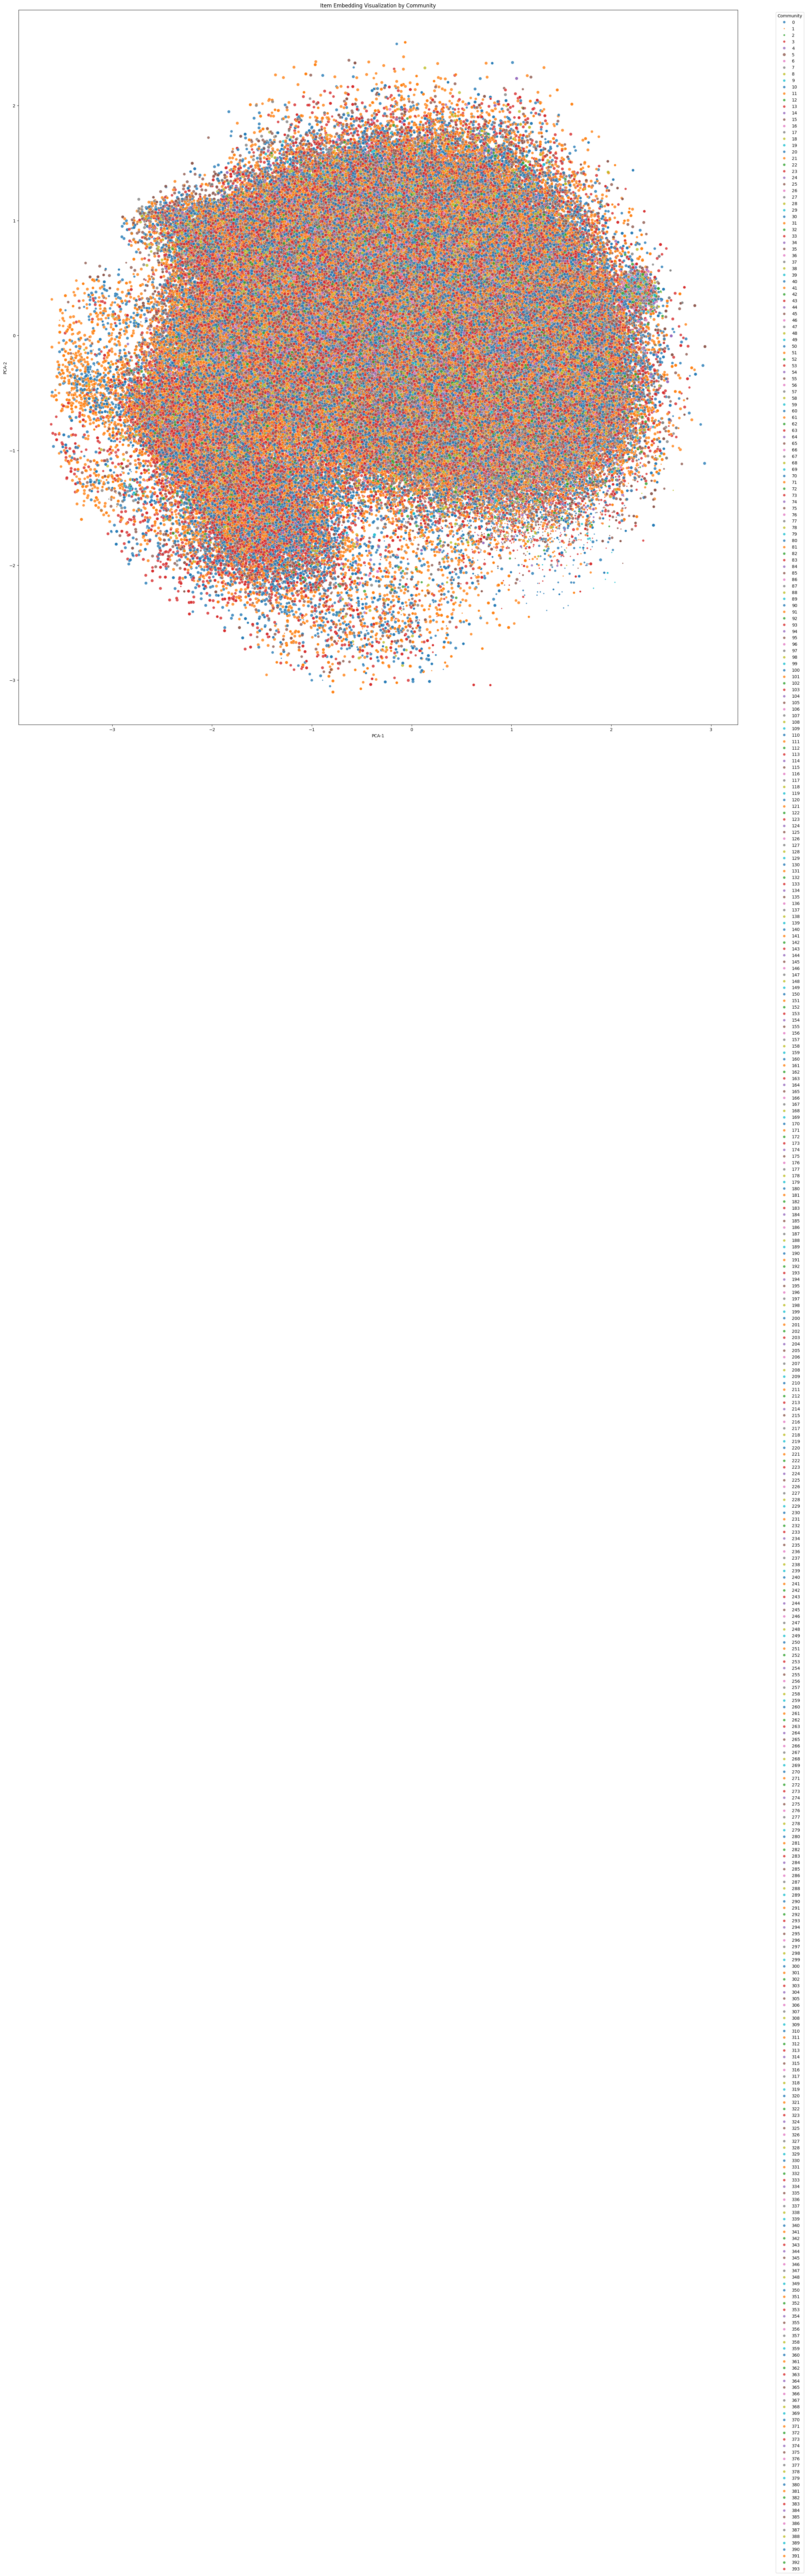

In [16]:
# Visualize item embedding distribution
item_labels = df['community_idx'].values
ratings = df['rating'].values
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(item_emb_matrix.cpu())

plt.figure(figsize=(30, 30))
sns.scatterplot(x=emb_2d[:, 0], y=emb_2d[:, 1], hue=item_labels, size=ratings,
                sizes=(10, 50), palette='tab10', alpha=0.8)
plt.title("Item Embedding Visualization by Community")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.legend(title='Community', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [17]:
# Define recommendation Model
user_idx = LabelEncoder().fit_transform(df['user_id'])
item_idx = LabelEncoder().fit_transform(df['business_id'])
comm_idx = df['community_idx'].values
rating_scaled = MinMaxScaler().fit_transform(df['rating'].values.reshape(-1, 1)).squeeze()

user_tensor = torch.tensor(user_idx)
item_tensor = torch.tensor(item_idx)
comm_tensor = torch.tensor(comm_idx)
label_tensor = torch.tensor(rating_scaled, dtype=torch.float32)

class RecommenderWithGATCommunity(nn.Module):
    def __init__(self, n_users, item_emb_matrix, n_comms, meta_dim):
        super().__init__()
        self.item_emb_matrix = item_emb_matrix
        self.u_emb = nn.Embedding(n_users, 32)
        self.c_emb = nn.Embedding(n_comms, 8)
        self.text_proj = nn.Linear(meta_dim // 2, meta_dim)
        self.img_proj = nn.Linear(meta_dim // 2, meta_dim)
        self.attn = nn.MultiheadAttention(meta_dim, 4, batch_first=True)
        self.norm = nn.LayerNorm(meta_dim)
        self.mlp = nn.Sequential(
            nn.Linear(32 + 32 + 8 + meta_dim + meta_dim, 128),
            nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, u, i, c, meta):
        u_vec = self.u_emb(u)
        i_vec = self.item_emb_matrix[i]
        c_vec = self.c_emb(c)
        t, v = meta[:, :meta.shape[1]//2], meta[:, meta.shape[1]//2:]
        t_proj = self.text_proj(t)
        v_proj = self.img_proj(v)
        attn_out, _ = self.attn(t_proj.unsqueeze(1), v_proj.unsqueeze(1), v_proj.unsqueeze(1))
        attn_out = self.norm(attn_out.squeeze(1) + t_proj)
        x = torch.cat([u_vec, i_vec, c_vec, t_proj, attn_out], dim=1)
        return self.mlp(x).squeeze()

In [23]:
# Train and validation
# Prepare Dataset (Saved on CPU)
train_idx, val_idx = train_test_split(np.arange(len(label_tensor)), test_size=0.2, random_state=42)

train_ds = TensorDataset(
    user_tensor[train_idx].cpu(),
    item_tensor[train_idx].cpu(),
    comm_tensor[train_idx].cpu(),
    meta_tensor[train_idx].cpu(),
    label_tensor[train_idx].cpu()
)
val_ds = TensorDataset(
    user_tensor[val_idx].cpu(),
    item_tensor[val_idx].cpu(),
    comm_tensor[val_idx].cpu(),
    meta_tensor[val_idx].cpu(),
    label_tensor[val_idx].cpu()
)

train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1024, shuffle=False, pin_memory=True, num_workers=0)


In [25]:
# Initialize the model
model = RecommenderWithGATCommunity(
    n_users=len(np.unique(user_idx)),
    item_emb_matrix=item_emb_matrix,
    n_comms=len(np.unique(comm_idx)),
    meta_dim=meta_tensor.shape[1]
).to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scaler = torch.cuda.amp.GradScaler()


<ipython-input-25-ee555eec893d>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [45]:
# Training Loop
best_rmse = float('inf')
patience = 3  # Early stopping patience
trigger_times = 0

train_losses = []
val_rmses = []

for epoch in range(1, 51):
    model.train()
    running_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)  # tqdm: Display training progress
    for u, i, c, meta, y in train_bar:
        u, i, c, meta, y = u.to(DEVICE), i.to(DEVICE), c.to(DEVICE), meta.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        with torch.autocast(device_type='cuda'):
            pred = model(u, i, c, meta)
            loss = criterion(pred, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    preds, truths = [], []
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)
        for u, i, c, meta, y in val_bar:
            u, i, c, meta, y = u.to(DEVICE), i.to(DEVICE), c.to(DEVICE), meta.to(DEVICE), y.to(DEVICE)
            out = model(u, i, c, meta).cpu().numpy()
            preds.append(out)
            truths.append(y.cpu().numpy())

    preds = np.concatenate(preds)
    truths = np.concatenate(truths)
    rmse = np.sqrt(mean_squared_error(truths, preds))
    val_rmses.append(rmse)

    print(f"Epoch {epoch} Summary: Train Loss = {avg_train_loss:.4f}, Val RMSE = {rmse:.4f}")

    # Early Stopping
    if rmse < best_rmse:
        best_rmse = rmse
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Model saved at epoch {epoch} with RMSE = {rmse:.4f}")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered after {patience} bad epochs.")
            break


Epoch 1 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 1 Summary: Train Loss = 0.0102, Val RMSE = 0.1552
Model saved at epoch 1 with RMSE = 0.1552


Epoch 2 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 2 Summary: Train Loss = 0.0095, Val RMSE = 0.1540
Model saved at epoch 2 with RMSE = 0.1540


Epoch 3 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 3 Summary: Train Loss = 0.0089, Val RMSE = 0.1565


Epoch 4 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 4 Summary: Train Loss = 0.0085, Val RMSE = 0.1551


Epoch 5 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 5 Summary: Train Loss = 0.0079, Val RMSE = 0.1577
Early stopping triggered after 3 bad epochs.


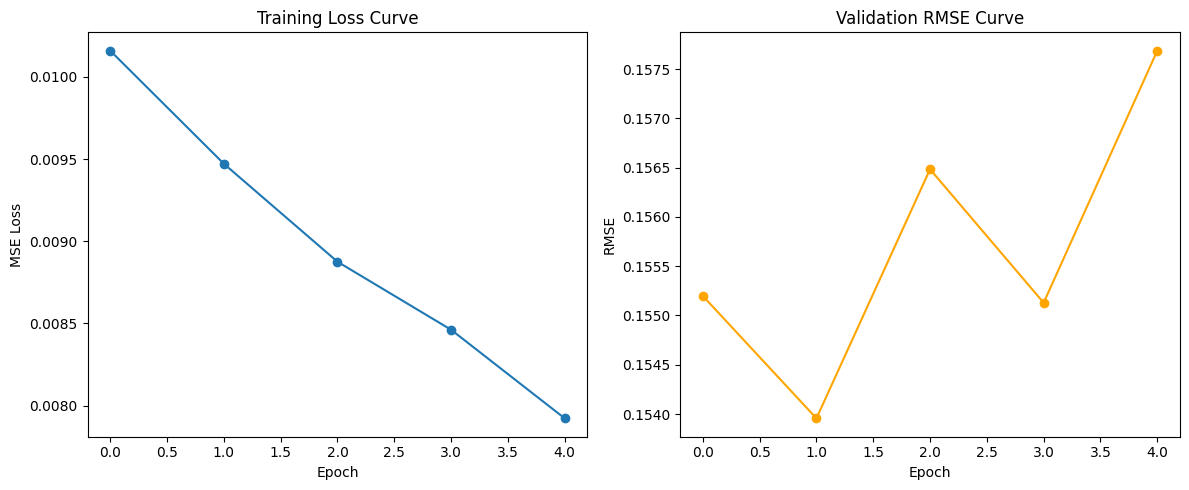

In [47]:
# Plot Training Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

plt.subplot(1, 2, 2)
plt.plot(val_rmses, marker='o', color='orange')
plt.title('Validation RMSE Curve')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()


In [33]:
def precision_at_k(ranked_items, ground_truth_items, k):
    ranked_items_k = ranked_items[:k]
    hits = len(set(ranked_items_k) & set(ground_truth_items))
    return hits / k

def recall_at_k(ranked_items, ground_truth_items, k):
    ranked_items_k = ranked_items[:k]
    hits = len(set(ranked_items_k) & set(ground_truth_items))
    return hits / len(ground_truth_items) if len(ground_truth_items) > 0 else 0.0

def ndcg_at_k(ranked_items, ground_truth_items, k):
    ranked_items_k = ranked_items[:k]
    dcg = 0.0
    for i, item in enumerate(ranked_items_k):
        if item in ground_truth_items:
            dcg += 1 / np.log2(i + 2)

    ideal_hits = min(len(ground_truth_items), k)
    if ideal_hits == 0:
        return 0.0
    idcg = sum(1 / np.log2(i + 2) for i in range(ideal_hits))

    return dcg / idcg

In [31]:
def evaluate_model_user_item_sampled(
    model,
    user_tensor,
    item_tensor,
    comm_tensor,
    meta_tensor,
    label_tensor,
    K=50,
    user_sample_size=10000,
    max_neg_per_user=1000,
    rating_threshold=3
):
    model.eval()

    if label_tensor.max() <= 1.0:
        print("[Warning] label_tensor appears normalized (max <= 1). Please ensure you are passing original ratings!")

    valid_users = user_tensor[label_tensor >= rating_threshold].unique().cpu().numpy()
    sampled_users = np.random.choice(valid_users, size=min(user_sample_size, len(valid_users)), replace=False)

    precision_list, recall_list, ndcg_list = [], [], []

    all_item_ids = item_tensor.cpu().numpy()
    print(f"Evaluating performance (user_sample={len(sampled_users)}, max_neg_per_user={max_neg_per_user}, threshold={rating_threshold})...")

    empty_user_count = 0

    for u in tqdm(sampled_users, desc="Evaluating Users"):
        ground_truth_items = item_tensor[(user_tensor == u) & (label_tensor >= rating_threshold)].cpu().numpy()

        if len(ground_truth_items) == 0:
            empty_user_count += 1
            continue

        # Dynamic negative sampling number = number of positive samples × 50, capped to max_neg_per_user
        neg_num = min(len(ground_truth_items) * 50, max_neg_per_user)

        neg_pool = list(set(all_item_ids) - set(ground_truth_items))
        if len(neg_pool) == 0:
            continue  # Prevent the negative sample pool from being empty

        sampled_negatives = np.random.choice(neg_pool, size=min(neg_num, len(neg_pool)), replace=False)

        candidates = np.concatenate([ground_truth_items, sampled_negatives])
        candidates_tensor = torch.tensor(candidates, dtype=torch.long)

        u_batch = torch.full((len(candidates_tensor),), u, dtype=torch.long).to(DEVICE)
        i_batch = candidates_tensor.to(DEVICE)
        c_batch = comm_tensor[candidates_tensor].to(DEVICE)
        meta_batch = meta_tensor[candidates_tensor].to(DEVICE)

        with torch.no_grad():
            scores = model(u_batch, i_batch, c_batch, meta_batch).cpu().numpy()

        ranked_indices = np.argsort(-scores)
        ranked_candidates = candidates[ranked_indices]

        precision = precision_at_k(ranked_candidates, ground_truth_items, K)
        recall = recall_at_k(ranked_candidates, ground_truth_items, K)
        ndcg = ndcg_at_k(ranked_candidates, ground_truth_items, K)

        precision_list.append(precision)
        recall_list.append(recall)
        ndcg_list.append(ndcg)

    if len(precision_list) == 0:
        print("[Warning] No valid users with ground truth found! Cannot compute metrics.")
        return np.nan, np.nan, np.nan

    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_ndcg = np.mean(ndcg_list)

    print(f"\nSampled Evaluation Results (K={K}):")
    print(f"Precision@{K}: {avg_precision:.4f}")
    print(f"Recall@{K}: {avg_recall:.4f}")
    print(f"NDCG@{K}: {avg_ndcg:.4f}")
    print(f"Skipped {empty_user_count} users with no valid ground truth.")

    return avg_precision, avg_recall, avg_ndcg, precision_list, recall_list, ndcg_list


In [34]:
precision, recall, ndcg, precision_list, recall_list, ndcg_list = evaluate_model_user_item_sampled(
    model,
    user_tensor,
    item_tensor,
    comm_tensor,
    meta_tensor,
    torch.tensor(df['rating'].values),  # Notice: the original rating is passed
    K=50,
    user_sample_size=10000,
    max_neg_per_user=1000,  # Dynamic negative sampling upper limit
    rating_threshold=3
)


Evaluating performance (user_sample=10000, max_neg_per_user=1000, threshold=3)...


Evaluating Users:   0%|          | 0/10000 [00:00<?, ?it/s]


Sampled Evaluation Results (K=50):
Precision@50: 0.0176
Recall@50: 0.7349
NDCG@50: 0.2099
Skipped 0 users with no valid ground truth.


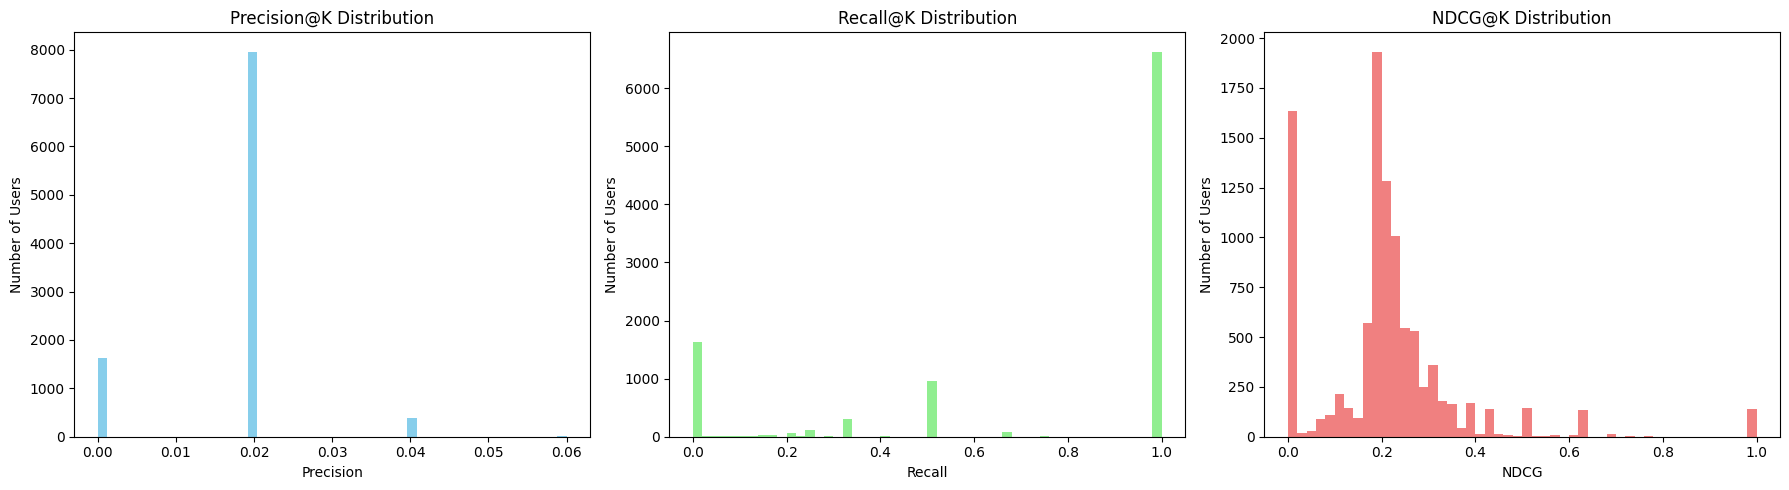

In [35]:
# Plot evaluation results
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(precision_list, bins=50, color='skyblue')
plt.title("Precision@K Distribution")
plt.xlabel("Precision")
plt.ylabel("Number of Users")

plt.subplot(1,3,2)
plt.hist(recall_list, bins=50, color='lightgreen')
plt.title("Recall@K Distribution")
plt.xlabel("Recall")
plt.ylabel("Number of Users")

plt.subplot(1,3,3)
plt.hist(ndcg_list, bins=50, color='lightcoral')
plt.title("NDCG@K Distribution")
plt.xlabel("NDCG")
plt.ylabel("Number of Users")

plt.tight_layout()
plt.show()